# [Hands-On] Prompt-based Image Classification with CLIP

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

This lecture is a part of the prompt-based classification explanation series, specifically focusing on **image classification** with the CLIP model in natural language processing (NLP) and computer vision tasks.

## What is CLIP?
CLIP (Contrastive Language–Image Pre-training) utilizes a novel approach by OpenAI, designed to understand images in context with natural language. This model bridges the gap between visual data and language, allowing it to perform a variety of vision-language tasks effectively, including image classification. By learning from a wide array of images and their corresponding text captions, CLIP models can generalize across a diverse set of domains without task-specific training.

In this notebook, we explore how the CLIP model can be applied to classify images, leveraging its capability to understand and interpret the content of images based on textual descriptions. Unlike traditional models that rely solely on visual cues, CLIP integrates textual understanding, offering a broader and more nuanced perspective.

## Objectives:
- Introduce the concept of CLIP and its revolutionary applications in bridging vision and language.
- Implement image classification using the CLIP model on a selected dataset of fruits.
- Analyze and discuss the results and insights gained from utilizing CLIP for image classification tasks.

Let's start by setting up our environment and importing the necessary libraries to dive into image classification with CLIP!


## Setup and Installation

In [ ]:
!pip install -qq datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
# Import necessary libraries
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

## Download and Load the Dataset

In [ ]:
!rm data.zip
!rm -r data
!wget -qq 'https://www.dropbox.com/scl/fi/mf806inzv0x6abbb2su0k/fruit-dataset.zip?rlkey=gk7s9d14m6k9o1ru4whrgtwke&dl=1' -O data.zip
!unzip -qq data.zip -d fruit-dataset/
!echo "Number of Images : $(find ./fruit-dataset -type f | wc -l)"

rm: cannot remove 'data.zip': No such file or directory
rm: cannot remove 'data': No such file or directory
Number of Images : 2000


In [ ]:
# Load the fruit dataset
from datasets import load_dataset
dataset = load_dataset("./fruit-dataset")

# Preview the dataset structure
print(dataset)

class_map = { k:v for k, v in enumerate(dataset['train'].features['label'].names) }
class_names = [v for k,v in class_map.items()]
print(class_map)
print(class_names)

Resolving data files:   0%|          | 0/1600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 400
    })
})
{0: 'apple', 1: 'asian pear', 2: 'banana', 3: 'cherry'}
['apple', 'asian pear', 'banana', 'cherry']


## Load the BLIP Model and Processor




**CLIP**:
CLIP (Contrastive Language-Image Pre-training) by OpenAI is a model that learns visual concepts from text data. It can categorize images based on textual descriptions without specific training for each task, using a zero-shot approach. This is achieved by training on diverse image-text pairs, which enhances its versatility across various visual tasks.

More about CLIP can be found on its [GitHub page](https://github.com/openai/CLIP/blob/main/README.md) and the detailed paper [here](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf).

**BLIP**:
BLIP is an advancement on CLIP, focusing on improving the efficiency and effectiveness of language-driven image understanding. It typically involves refined training processes to boost learning from vast amounts of image-text data, enhancing multimodal AI capabilities.

Here we load the model and its associated processor, preparing them for image processing and classification.

In [ ]:
# Load CLIP model and processor
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

## Preprocess the Data

In this section, we detail the preprocessing steps necessary for preparing the images for the BLIP model:
- Convert image files into a suitable format for the model.
- Process images using the CLIPProcessor to ensure they are compatible with the model input requirements.
- This step is crucial for maintaining consistency and accuracy in model predictions.

In [ ]:
import os
def classify_image(image, align_texts):
    # Check if the image is a file path
    if isinstance(image, str) and os.path.isfile(image):
        image = Image.open(image)
    elif not isinstance(image, Image.Image):
        # If the image is not a PIL Image and not a file path, raise an error
        raise ValueError("The provided image must be a PIL Image or a file path to an image.")
    # If 'image' is already a PIL Image, no conversion is needed

    # Process the image with the processor
    inputs = processor(text=align_texts, images=image, return_tensors="pt", padding=True)

    # To see the actual text used for alignment, inspect the tokenized text
    tokenized_text = inputs['input_ids']

    # Decode the tokenized text to see the human-readable format
    decoded_text = [processor.tokenizer.decode(ids) for ids in tokenized_text]

    # Move inputs to the device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  # Image-to-text similarity scores
        probs = logits_per_image.softmax(dim=1)
        pred_text_idx = torch.argmax(probs, dim=1)

    # Return the class name with the highest probability
    return pred_text_idx.item(), decoded_text, probs

## Evaluate the Model

### Classification via Prompt and Alignment - Simplified

The code implements a method for image classification by aligning text prompts with image features. Here’s a streamlined overview of how this works:

1. **Text Prompt Creation**: It generates descriptive texts for each class using predefined `query_templates`. These texts serve as natural language prompts that describe potential content of images.

2. **Image Processing and Alignment**:
    - The `classify_image` function checks if the input is a valid image or a path to an image file. If it’s a path, the image is loaded using the PIL library.
    - Text prompts are processed along with the image to create input tensors for the model. This involves tokenizing the text (converting text to a numerical format that the model can process) and preparing the image data.

3. **Model Prediction**:
    - The processed inputs are fed to a model that calculates similarity scores between the image and each text prompt. This step typically uses a neural network model that can evaluate the alignment between text and image features.
    - It applies a softmax function to these scores to derive probabilities that indicate how likely it is that the image matches each prompt.

4. **Output Generation**:
    - The system identifies the prompt with the highest probability score as the most accurate description of the image, effectively classifying the image.
    - Additionally, the function returns human-readable versions of the used prompts and the probability scores, providing insight into the model’s decision-making process.

This method leverages natural language to enhance the model's ability to classify images without needing explicit labels for every new image, supporting applications like zero-shot learning where the model classifies images based on descriptions it has not been explicitly trained on.

In [ ]:
query_templates = [
    "This is an image of a {image}.",
    "Here we see a {image}.",
    "The photo depicts a {image}.",
    "In this picture, there is a {image}.",
    "This picture shows a {image}.",
    "A {image} is present in this image.",
    "You can see a {image} here.",
    "This image represents a {image}.",
    "A {image} is captured in this shot.",
    "The object in this image is a {image}."
]

def get_n_query_texts(class_name, N):
    query_texts = [template.format(image=class_name) for template in query_templates[:N]]
    return query_texts

def make_query_texts(class_names, N):
    class_and_texts_map = []

    def prepend_a_or_an(word):
        # List of vowels
        vowels = 'aeiou'

        # Check if the first letter of the word is a vowel
        if word[0].lower() in vowels:
            return f"an {word}"
        else:
            return f"a {word}"

    for cls in class_names:
        query_texts = get_n_query_texts(cls, N)
        items = [ (cls, q) for q in query_texts ]
        class_and_texts_map += items

    return class_and_texts_map

def do_prompt_based_image_classification(image_path, N=1):
    class_and_texts_map = make_query_texts(class_names, N)
    query_texts = [x[1] for x in class_and_texts_map]
    best_aligned_text_idx, actual_query_texts, probs = classify_image(image_path, query_texts)
    return best_aligned_text_idx, actual_query_texts, class_and_texts_map, probs.softmax(-1)

In [ ]:
image_path = "./fruit-dataset/test/apple/apple_401.png"
best_aligned_text_idx, actual_query_texts, class_and_texts_map, probs = do_prompt_based_image_classification(image_path)

In [ ]:
best_aligned_text_idx

0

In [ ]:
actual_query_texts

['<|startoftext|>this is an image of a apple. <|endoftext|><|endoftext|>',
 '<|startoftext|>this is an image of a asian pear. <|endoftext|>',
 '<|startoftext|>this is an image of a banana. <|endoftext|><|endoftext|>',
 '<|startoftext|>this is an image of a cherry. <|endoftext|><|endoftext|>']

In [ ]:
class_and_texts_map

[('apple', 'This is an image of a apple.'),
 ('asian pear', 'This is an image of a asian pear.'),
 ('banana', 'This is an image of a banana.'),
 ('cherry', 'This is an image of a cherry.')]

In [ ]:
probs

tensor([[0.4009, 0.1855, 0.1844, 0.2291]])

### Visualize Predictions

This subsection focuses on visualizing the classification results. It describes how to load and display images with their predicted class labels, enhancing the interpretability of the model's outputs.


In [ ]:
import matplotlib.pyplot as plt

def visualize_classification(image_path, best_align_text_idx, class_and_texts_map, probs):
    # Load and display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide the axis

    probability = probs[0][best_align_text_idx]
    class_label, text = class_and_texts_map[best_align_text_idx]

    plt.title(f"Best aligned text: {text}\nPredicted Class: {class_label }\nProbability: {probability:.4f}", loc='left')

    # Show the plot
    plt.show()

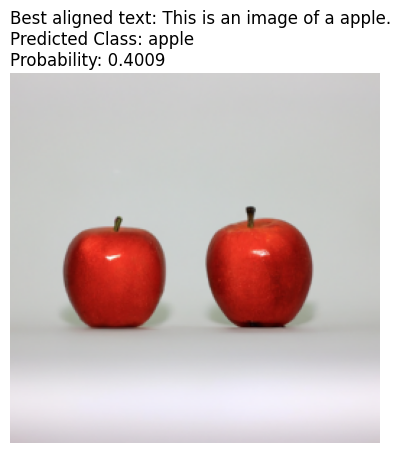

In [ ]:
image_path = "./fruit-dataset/test/apple/apple_401.png"
best_align_text_idx, actual_query_texts, class_and_texts_map, probs = do_prompt_based_image_classification(image_path)
visualize_classification(image_path, best_align_text_idx, class_and_texts_map, probs)

### Conducting evaluation across multiple datasets

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import sample

true_labels = []
predicted_labels = []

r_class_map = { v:k for k, v in class_map.items() }

# Generate a list of random indices based on the length of the dataset
num_samples = 200
random_indices = sample(range(len(dataset['test'])), num_samples)

#for item in tqdm(dataset['test']):
for item in tqdm(dataset['test'].select(random_indices)):
    image = item['image']
    true_label = item['label']
    true_labels.append(true_label)

    best_aligned_text_idx, actual_query_texts, class_and_texts_map, probs = do_prompt_based_image_classification(image)
    pred_class_label = class_and_texts_map[best_aligned_text_idx][0]
    predicted_labels.append(r_class_map[pred_class_label])

100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


Accuracy: 0.9350
Precision: 0.9394
Recall: 0.9350
F1-score: 0.9347


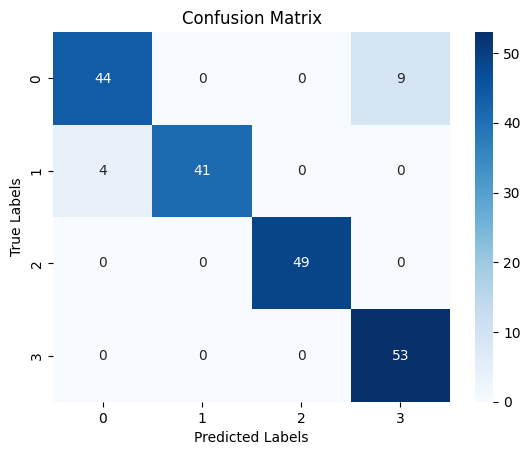

In [ ]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

true_labels

In [ ]:
class_and_texts_map

[('apple', 'This is an image of a apple.'),
 ('asian pear', 'This is an image of a asian pear.'),
 ('banana', 'This is an image of a banana.'),
 ('cherry', 'This is an image of a cherry.')]

In [ ]:
probs

tensor([[0.1750, 0.1749, 0.1749, 0.4752]])

### Multiple query texts for the corresponding classes

This part of the code introduces more complex classification strategies, such as using multiple query templates to refine the model's accuracy.

Given the structure of your `class_and_texts_map` and the probability scores probs for each text query associated with an image, we can aggregate the probabilities for each class by summing them and then pick the class with the highest aggregated probability as the prediction. It provides an insight into how different queries can affect the model's prediction results.


In [ ]:
def merge_multiple_query_result(class_and_texts_map, probs):
    # Initialize a dictionary to hold the sum of probabilities for each class
    class_probs = {}

    # Iterate over class_and_texts_map and probs to aggregate probabilities
    for idx, (class_name, _) in enumerate(class_and_texts_map):
        if class_name not in class_probs:
            class_probs[class_name] = 0
        class_probs[class_name] += probs[0][idx].item()  # Convert from tensor to float and add to the class's total probability

    # Find the class with the highest aggregated probability
    predicted_class = max(class_probs, key=class_probs.get)
    return predicted_class, class_probs[predicted_class]

true_labels = []
predicted_labels = []

for item in tqdm(dataset['test'].select(random_indices)):
    image = item['image']
    true_label = item['label']
    true_labels.append(true_label)

    best_aligned_text_idx, actual_query_texts, class_and_texts_map, probs = do_prompt_based_image_classification(image, N=5)

    pred_class_label, pred_merged_prob = merge_multiple_query_result(class_and_texts_map, probs)
    predicted_labels.append(r_class_map[pred_class_label])

100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


In [ ]:
class_and_texts_map

[('apple', 'This is an image of a apple.'),
 ('apple', 'Here we see a apple.'),
 ('apple', 'The photo depicts a apple.'),
 ('apple', 'In this picture, there is a apple.'),
 ('apple', 'This picture shows a apple.'),
 ('asian pear', 'This is an image of a asian pear.'),
 ('asian pear', 'Here we see a asian pear.'),
 ('asian pear', 'The photo depicts a asian pear.'),
 ('asian pear', 'In this picture, there is a asian pear.'),
 ('asian pear', 'This picture shows a asian pear.'),
 ('banana', 'This is an image of a banana.'),
 ('banana', 'Here we see a banana.'),
 ('banana', 'The photo depicts a banana.'),
 ('banana', 'In this picture, there is a banana.'),
 ('banana', 'This picture shows a banana.'),
 ('cherry', 'This is an image of a cherry.'),
 ('cherry', 'Here we see a cherry.'),
 ('cherry', 'The photo depicts a cherry.'),
 ('cherry', 'In this picture, there is a cherry.'),
 ('cherry', 'This picture shows a cherry.')]

Accuracy: 0.9400
Precision: 0.9436
Recall: 0.9400
F1-score: 0.9398


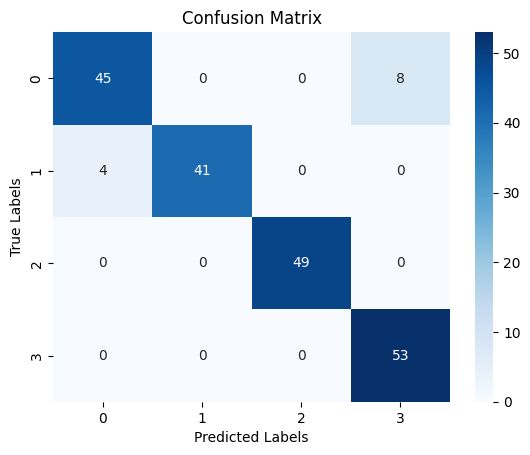

In [ ]:
# Calculate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

This tutorial has explored the innovative approach of using the CLIP (or BLIP) model for image classification. We have implemented various stages from data loading and preprocessing to model evaluation, utilizing advanced techniques like multiple query templates. I hope this article has helped you understand the advantages and potential of prompt-based classification.